

## HEOM Fermion: Discrete boson coupled to an impurity

Here we model a single fermion coupled to two electronic leads or reservoirs (e.g.,  this can describe a single quantum dot, a molecular transistor, etc), also coupled to a discrete bosonic (vibronic) mode.  

Note that in this implementation we primarily follow the definitions used by Christian Schinabeck in his Dissertation https://opus4.kobv.de/opus4-fau/files/10984/DissertationChristianSchinabeck.pdf and related publications. In particular this example reproduces some results from https://journals.aps.org/prb/abstract/10.1103/PhysRevB.94.201407


Notation:  
$K=L/R$ refers to  left or right leads.

$\sigma=\pm$ refers to input/output


We choose a Lorentzian spectral density for the leads, with a peak at the chemical potential. The latter simplifies a little the notation required for the correlation functions, but can be relaxed if neccessary.

$$J(\omega) = \frac{\Gamma  W^2}{((\omega-\mu_K)^2 +W^2 )}$$


Fermi distribution is

$$f_F (x) = (\exp(x) + 1)^{-1}$$

gives correlation functions

$$C^{\sigma}_K(t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} d\omega e^{\sigma i \omega t} \Gamma_K(\omega) f_F[\sigma\beta(\omega - \mu)]$$


As with the Bosonic case we can treat these with Matsubara, Pade, or fitting approaches.

The Pade decomposition approximates the Fermi distubition as 

$$f_F(x) \approx f_F^{\mathrm{approx}}(x) = \frac{1}{2} - \sum_l^{l_{max}} \frac{2k_l x}{x^2 + \epsilon_l^2}$$

$k_l$ and $\epsilon_l$ are co-efficients defined in J. Chem Phys 133,10106

Evaluating the integral for the correlation functions gives,


$$C_K^{\sigma}(t) \approx \sum_{l=0}^{l_{max}} \eta_K^{\sigma_l} e^{-\gamma_{K,\sigma,l}t}$$

where

$$\eta_{K,0} = \frac{\Gamma_KW_K}{2} f_F^{approx}(i\beta_K W)$$

$$\gamma_{K,\sigma,0} = W_K - \sigma i\mu_K$$ 

$$\eta_{K,l\neq 0} = -i\cdot \frac{k_m}{\beta_K} \cdot \frac{\Gamma_K W_K^2}{-\frac{\epsilon^2_m}{\beta_K^2} + W_K^2}$$

$$\gamma_{K,\sigma,l\neq 0}= \frac{\epsilon_m}{\beta_K} - \sigma i \mu_K$$  


The system is how described by the single impurity model coupled to a discrete bosonic mode

$$
H_{\mathrm{vib}} = H_{\mathrm{SIAM}} + \Omega a^{\dagger}a + \lambda (a+a^{\dagger})c{^\dagger}c.
$$




In [1]:
#Imports
from qutip import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/shahnawaz/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shape', 'identity', 'info', 'squeeze']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#import heom_fermions_1 as heom_fermions

from heom.heom_fmotd import FermionicHEOMSolver #c version
from heom.heom_fmotd_py import FermionicHEOMSolver as FermionicHEOMSolverPy #python version
import time
from scipy.integrate import quad

options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)


In [4]:
def deltafun(j,k):
    if j==k: 
        return 1.
    else:
        return 0.

In [5]:

from qutip.states import enr_state_dictionaries

def get_aux_matrices(full, level, N_baths, Nk, N_cut, shape, dims):
    """
    Extracts the auxiliary matrices at a particular level
    from the full hierarchy ADOs.
    
    Parameters
    ----------
    full: ndarray
        A 2D array of the time evolution of the ADOs.
    
    level: int
        The level of the hierarchy to get the ADOs.
        
    N_cut: int
        The hierarchy cutoff.
    
    k: int
        The total number of exponentials used in each bath (assumed equal).
    
    N_baths: int
        The number of baths.
        
    shape : int
        the size of the ''system'' hilbert space
        
    dims : list
        the dimensions of the system hilbert space
    """
    #Note: Max N_cut is Nk*N_baths
    nstates, state2idx, idx2state = enr_state_dictionaries([2]*(Nk*N_baths) ,N_cut)#_heom_state_dictionaries([Nc + 1]*(Nk), Nc)
    aux_indices = []
    
    aux_heom_indices = []
    for stateid in state2idx:
        if np.sum(stateid) == level:
            aux_indices.append(state2idx[stateid])
            aux_heom_indices.append(stateid)
    full = np.array(full)
    aux = []

    for i in aux_indices:
        qlist = [Qobj(full[k, i, :].reshape(shape, shape).T,dims=dims) for k in range(len(full))]
        aux.append(qlist)
    return aux, aux_heom_indices, idx2state

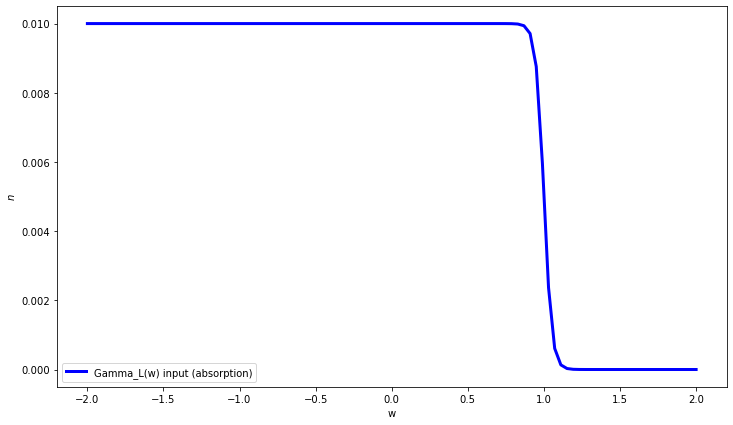

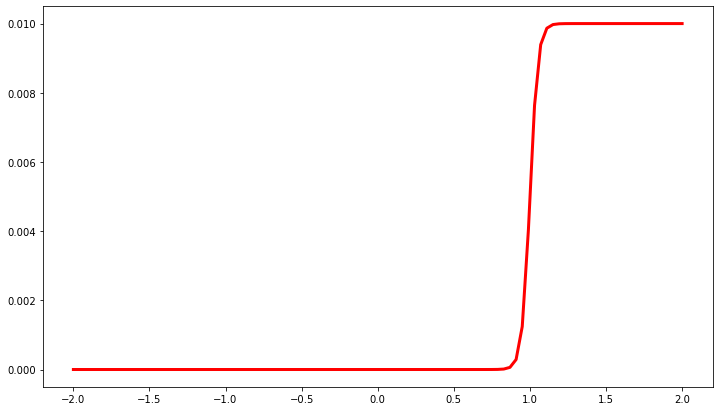

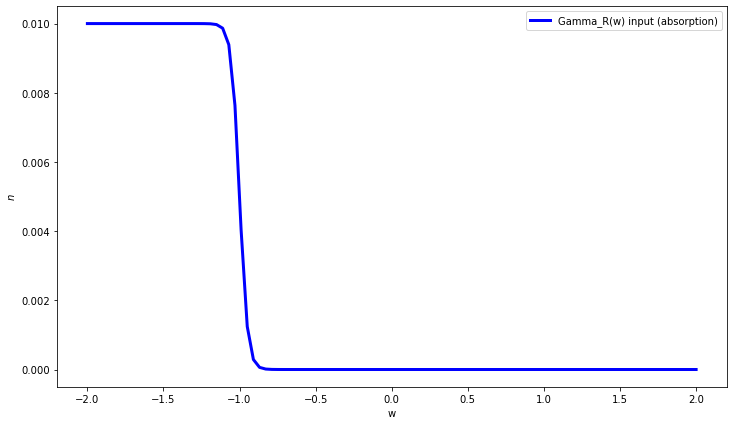

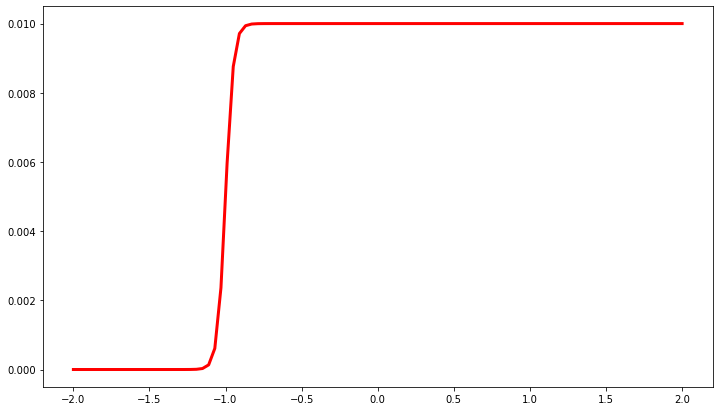

In [6]:
#parameters and spectra check

#thoss
Gamma = 0.01

W = 10**4

 
T = 0.025851991 #in ev
beta = 1./T

theta = 2.
mu_l = theta/2.
mu_r = -theta/2.

w_list = np.linspace(-2,2,100)

def Gamma_L_w(w):
    return Gamma*W**2/((w-mu_l)**2 + W**2)

def Gamma_R_w(w):
    return Gamma*W**2/((w-mu_r)**2 + W**2)


def f(x):
    kB=1.
    return 1/(exp(x)+1.)
def f2(x):
    return 0.5

fig, ax1 = plt.subplots(figsize=(12, 7))
gam_list_in = [Gamma_L_w(w)*f(beta*(w-mu_l)) for w in w_list]

ax1.plot(w_list,gam_list_in, color="b", linewidth=3, label= r"Gamma_L(w) input (absorption)")


ax1.set_xlabel("w")
ax1.set_ylabel(r"$n$")
ax1.legend()
fig, ax2 = plt.subplots(figsize=(12, 7))

gam_list_out = [Gamma_L_w(w)*f(-beta*(w-mu_l)) for w in w_list]
spec = [Gamma_L_w(w) for w in w_list]

ax2.plot(w_list,gam_list_out, color="r", linewidth=3, label= r"Gamma_L(w) output (emission)")

fig, ax1 = plt.subplots(figsize=(12, 7))
gam_list_in = [Gamma_R_w(w)*f(beta*(w-mu_r)) for w in w_list]

ax1.plot(w_list,gam_list_in, color="b", linewidth=3, label= r"Gamma_R(w) input (absorption)")


ax1.set_xlabel("w")
ax1.set_ylabel(r"$n$")
ax1.legend()
fig, ax2 = plt.subplots(figsize=(12, 7))

gam_list_out = [Gamma_R_w(w)*f(-beta*(w-mu_r)) for w in w_list]
spec = [Gamma_R_w(w) for w in w_list]

ax2.plot(w_list,gam_list_out, color="r", linewidth=3, label= r"Gamma_R(w) output (emission)")


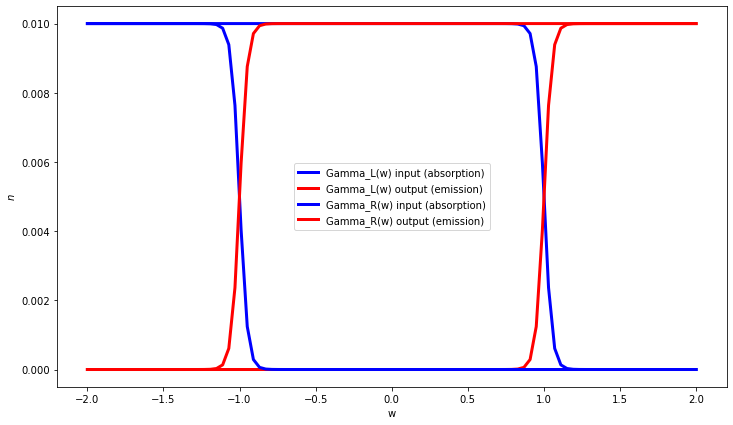

In [7]:

fig, ax1 = plt.subplots(figsize=(12, 7))
gam_list_in = [Gamma_L_w(w)*f(beta*(w-mu_l)) for w in w_list]

ax1.plot(w_list,gam_list_in, color="b", linewidth=3, label= r"Gamma_L(w) input (absorption)")

#ax1.set_ylim(0, 0.1)
ax1.set_xlabel("w")
ax1.set_ylabel(r"$n$")
ax1.legend()


gam_list_out = [Gamma_L_w(w)*f(-beta*(w-mu_l)) for w in w_list]
spec = [Gamma_L_w(w) for w in w_list]
#print(gam_list)
ax1.plot(w_list,gam_list_out, color="r", linewidth=3, label= r"Gamma_L(w) output (emission)")

gam_list_in = [Gamma_R_w(w)*f(beta*(w-mu_r)) for w in w_list]

ax1.plot(w_list,gam_list_in, color="b", linewidth=3, label= r"Gamma_R(w) input (absorption)")



gam_list_out = [Gamma_R_w(w)*f(-beta*(w-mu_r)) for w in w_list]
spec = [Gamma_R_w(w) for w in w_list]

ax1.plot(w_list,gam_list_out, color="r", linewidth=3, label= r"Gamma_R(w) output (emission)")

ax1.set_xlabel("w")
ax1.set_ylabel(r"$n$")
ax1.legend()

### Below we collate data sets

We try different cut-offs of the bosonic Fock space and the expansion of the correlation functions. We only calculate the steady-state current here.

One note:  for very large problems, this can be extremely slow. Using the MKL solver here helps a great deal, but can have convergence problems in the worst cases. 

In [ ]:



rhoHssPlistl4n2N34 = []
fullssPlistl4n2N34 = []

theta_list = np.linspace(0,2,30)

tlist = np.linspace(0,10,200)

for theta in theta_list:
    print("------------- theta:",theta)
    mu_l = theta/2.
    mu_r = -theta/2.



    lmax = 4





    def Gamma_L_w(w):
        return Gamma*W**2/((w-mu_l)**2 + W**2)

    def Gamma_w(w, mu):
        return Gamma*W**2/((w-mu)**2 + W**2)


    def f(x):
        kB=1.
        return 1/(exp(x)+1.)



    Alpha =np.zeros((2*lmax,2*lmax))
    for j in range(2*lmax):
        for k in range(2*lmax):
            Alpha[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+1)-1)*(2*(k+1)-1))

    eigvalsA=eigvalsh(Alpha)  

    eps = []
    for val in  eigvalsA[0:lmax]:
        #print(-2/val)
        eps.append(-2/val)


    AlphaP =np.zeros((2*lmax-1,2*lmax-1))
    for j in range(2*lmax-1):
        for k in range(2*lmax-1):
            AlphaP[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+1)+1)*(2*(k+1)+1))
            #AlphaP[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+2)-1)*(2*(k+2)-1))

    eigvalsAP=eigvalsh(AlphaP)    


    chi = []
    for val in  eigvalsAP[0:lmax-1]:
        #print(-2/val)
        chi.append(-2/val)


    eta_list=[0.5*lmax*(2*(lmax + 1) - 1)*( 
      np.prod([chi[k]**2 - eps[j]**2 for k in range(lmax - 1)])/
        np.prod([eps[k]**2 - eps[j]**2 +deltafun(j,k) for k in range(lmax)])) 
              for j in range(lmax)]


 
    kappa = [0]+eta_list
    print(kappa)

    epsilon = [0]+eps
    print(epsilon)
    def f_approx(x):
        f = 0.5
        for l in range(1,lmax+1):
            f= f - 2*kappa[l]*x/(x**2+epsilon[l]**2)
        return f

    def f(x):
        kB=1.
        return 1/(exp(x)+1.)




    def C(tlist,sigma,mu):
        eta_list = []
        gamma_list  =[]

        eta_0 = 0.5*Gamma*W*f_approx(1.0j*beta*W)
        #eta_0 = 0.5*Gamma*W*f(1.0j*beta*W)
        gamma_0 = W - sigma*1.0j*mu
        eta_list.append(eta_0)
        gamma_list.append(gamma_0)
        if lmax>0:
            for l in range(1,lmax+1):
                eta_list.append(-1.0j*(kappa[l]/beta)*Gamma*W**2/(-(epsilon[l]**2/beta**2)+W**2))
                gamma_list.append(epsilon[l]/beta - sigma*1.0j*mu)
        c_tot = []
        for t in tlist:
            c_tot.append(sum([eta_list[l]*exp(-gamma_list[l]*t) for l in range(lmax+1)]))
        return c_tot, eta_list, gamma_list



    def c_t_L_num(t,sigma,mu):

        integrand = lambda w: (1/(2*pi))*exp(sigma*1.0j*w*t)*Gamma_w(w,mu)*f(sigma*beta*(w-mu))
        def real_func(x):
            return scipy.real(integrand(x))
        def imag_func(x):
            return scipy.imag(integrand(x))


        a= -10**6
        b=10**6
        real_integral = quad(real_func, a, b)
        imag_integral = quad(imag_func, a, b)
        return real_integral[0] + 1.0j * imag_integral[0]




    cppL,etapL,gampL = C(tlist,1.0,mu_l)

    cpmL,etamL,gammL = C(tlist,-1.0,mu_l)



    cppR,etapR,gampR = C(tlist,1.0,mu_r)

    cpmR,etamR,gammR = C(tlist,-1.0,mu_r)



    Nbos = 34

    d1 = tensor(destroy(2), qeye(Nbos))

    a = tensor(qeye(2), destroy(Nbos))

    e1 = 0.3 #d1 = spin up
    Omega = 0.2
    Lambda = 0.12

    H0 = e1*d1.dag()*d1 + Omega * a.dag()*a + Lambda * (a+a.dag())*d1.dag()*d1

    Qops = [d1.dag(),d1,d1.dag(),d1]


    rho_0 = tensor(basis(2,0)*basis(2,0).dag(),basis(Nbos,0)*basis(Nbos,0).dag())

    Kk=lmax+1

    Ncc = 2

    eta_list = [etapR,etamR,etapL,etamL]

    print(eta_list)
    gamma_list = [gampR,gammR,gampL,gammL]
    print(gamma_list)
    
    import time

    start = time.time()
    
    resultHEOM=FermionicHEOMSolver(H0, Qops,  eta_list, gamma_list,  Ncc, options=options)
    end = time.time()
    print("construct time new code:", end - start)

    start = time.time()


    rhossHP,fullssP=resultHEOM.steady_state(use_mkl=False)
    end = time.time()
    print("ss time new",end - start)
  
    rhoHssPlistl4n2N34.append(rhossHP)
    fullssPlistl4n2N34.append(fullssP)
   

In [ ]:


rhoHssPlistl6n2N16 = []
fullssPlistl6n2N16 = []

theta_list = np.linspace(0,2,30)

for theta in theta_list:
    print("------------- theta:",theta)
    mu_l = theta/2.
    mu_r = -theta/2.



    lmax = 6



    def Gamma_L_w(w):
        return Gamma*W**2/((w-mu_l)**2 + W**2)

    def Gamma_w(w, mu):
        return Gamma*W**2/((w-mu)**2 + W**2)


    def f(x):
        kB=1.
        return 1/(exp(x)+1.)




    Alpha =np.zeros((2*lmax,2*lmax))
    for j in range(2*lmax):
        for k in range(2*lmax):
            Alpha[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+1)-1)*(2*(k+1)-1))

    eigvalsA=eigvalsh(Alpha)  

    eps = []
    for val in  eigvalsA[0:lmax]:

        eps.append(-2/val)


    AlphaP =np.zeros((2*lmax-1,2*lmax-1))
    for j in range(2*lmax-1):
        for k in range(2*lmax-1):
            AlphaP[j][k] = (deltafun(j,k+1)+deltafun(j,k-1))/sqrt((2*(j+1)+1)*(2*(k+1)+1))
           

    eigvalsAP=eigvalsh(AlphaP)    


    chi = []
    for val in  eigvalsAP[0:lmax-1]:

        chi.append(-2/val)


    eta_list=[0.5*lmax*(2*(lmax + 1) - 1)*( 
      np.prod([chi[k]**2 - eps[j]**2 for k in range(lmax - 1)])/
        np.prod([eps[k]**2 - eps[j]**2 +deltafun(j,k) for k in range(lmax)])) 
              for j in range(lmax)]


  
    kappa = [0]+eta_list
    print(kappa)

    epsilon = [0]+eps
    print(epsilon)
    def f_approx(x):
        f = 0.5
        for l in range(1,lmax+1):
            f= f - 2*kappa[l]*x/(x**2+epsilon[l]**2)
        return f

    def f(x):
        kB=1.
        return 1/(exp(x)+1.)



    def C(tlist,sigma,mu):
        eta_list = []
        gamma_list  =[]

        #l = 0
        eta_0 = 0.5*Gamma*W*f_approx(1.0j*beta*W)
        #eta_0 = 0.5*Gamma*W*f(1.0j*beta*W)
        gamma_0 = W - sigma*1.0j*mu
        eta_list.append(eta_0)
        gamma_list.append(gamma_0)
        if lmax>0:
            for l in range(1,lmax+1):
                eta_list.append(-1.0j*(kappa[l]/beta)*Gamma*W**2/(-(epsilon[l]**2/beta**2)+W**2))
                gamma_list.append(epsilon[l]/beta - sigma*1.0j*mu)
        c_tot = []
        for t in tlist:
            c_tot.append(sum([eta_list[l]*exp(-gamma_list[l]*t) for l in range(lmax+1)]))
        return c_tot, eta_list, gamma_list



    def c_t_L_num(t,sigma,mu):

        integrand = lambda w: (1/(2*pi))*exp(sigma*1.0j*w*t)*Gamma_w(w,mu)*f(sigma*beta*(w-mu))
        def real_func(x):
            return scipy.real(integrand(x))
        def imag_func(x):
            return scipy.imag(integrand(x))
   
        a= -10**6
        b=10**6
        real_integral = quad(real_func, a, b)
        imag_integral = quad(imag_func, a, b)
        return real_integral[0] + 1.0j * imag_integral[0]


    cppL,etapL,gampL = C(tlist,1.0,mu_l)

    cpmL,etamL,gammL = C(tlist,-1.0,mu_l)

 

    cppR,etapR,gampR = C(tlist,1.0,mu_r)

    cpmR,etamR,gammR = C(tlist,-1.0,mu_r)


    Nbos = 16

    d1 = tensor(destroy(2), qeye(Nbos))

    a = tensor(qeye(2), destroy(Nbos))

    e1 = 0.3 #d1 = spin up
    Omega = 0.2
    Lambda = 0.12

    H0 = e1*d1.dag()*d1 + Omega * a.dag()*a + Lambda * (a+a.dag())*d1.dag()*d1


    Qops = [d1.dag(),d1,d1.dag(),d1]


    rho_0 = tensor(basis(2,0)*basis(2,0).dag(),basis(Nbos,0)*basis(Nbos,0).dag())

    Kk=lmax+1

    Ncc = 2

    eta_list = [etapR,etamR,etapL,etamL]
    
    print(eta_list)
    gamma_list = [gampR,gammR,gampL,gammL]
    print(gamma_list)
    
    import time
    
    start = time.time()
    
    resultHEOM=FermionicHEOMSolver(H0, Qops,  eta_list, gamma_list,  Ncc, options=options)
    end = time.time()
    print("construct time new code:", end - start)
   
    start = time.time()

    rhossHP,fullssP=resultHEOM.steady_state(use_mkl=False)
    end = time.time()
    print("ss time ",end - start)
    
   
    
    rhoHssPlistl6n2N16.append(rhossHP)
    fullssPlistl6n2N16.append(fullssP)
  


In [ ]:
#we get the current from the first order ADOS stored in fullss*


aux_1_list_list=[]
aux1_indices_list=[]
aux_2_list_list=[]
aux2_indices_list=[]

K = Kk


shape = H0.shape[0]
dims = H0.dims
aux_1_list, aux1_indices, idx2state = get_aux_matrices(fullssPlistl6n2N16, 1, 4, K, Ncc, shape, dims)
aux_2_list, aux2_indices, idx2state = get_aux_matrices(fullssPlistl6n2N16, 2, 4, K, Ncc, shape, dims)



d1 = tensor(destroy(2), qeye(Nbos))   #Kk to 2*Kk

currPl6n2N16 = [1.0j * (((sum([(d1*aux_1_list[gg][thet]).tr() for gg in range(Kk,2*Kk)])))  \
                      -  ((sum([(d1.dag()*aux_1_list[gg][thet]).tr() for gg in range(Kk)])))) \
                for thet, thet2 in enumerate(theta_list)]

In [ ]:
currPunitsl6n2N16 = [curr*2.434e-4*1e6 for curr in currPl6n2N16]

In [ ]:
# qsave(currPunitsl4n2N34,'currPunitsl4n2N34v4')
# qsave(currPunitsl5n2N34,'currPunitsl5n2N34v4')
# qsave(currPunitsl5n2N16,'currPunitsl5n2N16v4')
# qsave(currPunitsl6n2N16,'currPunitsl6n2N36v4')


In [ ]:
# currPunitsl4n2N34=qload('currPunitsl4n2N34v4')
# currPunitsl5n2N34=qload('currPunitsl5n2N34v4')
# currPunitsl5n2N16=qload('currPunitsl5n2N16v4')
# currPunitsl6n2N16=qload('currPunitsl6n2N36v4')


In [ ]:
matplotlib.rcParams['figure.figsize'] = (7, 5)
matplotlib.rcParams['axes.titlesize'] = 25
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['lines.markersize'] = 5
matplotlib.rcParams['font.family'] = 'STIXGeneral' 
matplotlib.rcParams['mathtext.fontset'] =  'stix'

In [ ]:


fig, ax1 = plt.subplots(figsize=(12, 10))


ax1.plot(theta_list,currPunitsl5n2N16, color="green", linestyle='-', linewidth=3, label= r"$l_{max}=5$, $n_{max} = 2$, $N = 16$")
ax1.plot(theta_list,currPunitsl6n2N16, color="blue", linestyle=':', linewidth=3, label= r"$l_{max}=6$, $n_{max} = 2$, $N = 16$")

ax1.plot(theta_list,currPunitsl4n2N34, color="black", linestyle='-.', linewidth=3, label= r"$l_{max}=4$, $n_{max}= 2$, $N = 34$")
ax1.plot(theta_list,currPunitsl5n2N34, color="red", linestyle='--', linewidth=3, label= r"$l_{max}=5$, $n_{max} = 2$, $N = 34$")



ax1.locator_params(axis='y', nbins=6)
ax1.locator_params(axis='x', nbins=6)

ax1.set_xlabel(r"bias voltage $\theta$ ($V$)", fontsize=28 )
ax1.set_ylabel(r"Current ($\mu A$)", fontsize=28)
ax1.legend()
# plt.savefig("figImpBos.pdf")